## Mounting Environemnt If On Colab

In [1]:
# # If you are working in Colab, then consider mounting your assignment folder to your drive
# from google.colab import drive
# drive.mount('/content/drive')

# # # Direct to your assignment folder.
# %cd /content/drive/MyDrive/ColabNotebooks/Semester_Project_II/zebra_SAM

## Installing Environment Requirements. Only Do Once If Project Is Local

In [1]:
!sudo apt install imagemagick

Sudo is disabled on this machine. To enable it, go to the ]8;;ms-settings:developers\Developer Settings page]8;;\ in the Settings app


In [2]:
!apt-get install -y libmagickwand-dev

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

ERROR: Package 'transformers' requires a different Python: 3.9.23 not in '>=3.10.0'


In [4]:
!pip install -r requirements.txt

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import random
import os
import glob
import time
import warnings
import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
# import opendatasets as od
import datasets as dts

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from statistics import mean


import torch
import monai
import cv2
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
import re
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from monai.transforms import Compose, NormalizeIntensityd
from monai.metrics import compute_iou
from sklearn.model_selection import train_test_split
from skimage.transform import resize

from transformers import SamProcessor
from transformers import SamModel

# Custom .py files
# from generate_data_folder import generate_data_folder
from tiff_to_jpgs import adjust_jpg
from train_test_functions import train_test_model
from train_test_functions import test_with_visualization

# CONFIGURATION

In [6]:
plt.style.use("dark_background")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [7]:
class CFG:
    DATASET_PATH = "data/"
    TRAIN_PATH = "data/"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TRAIN_BATCH_SIZE = 2
    TEST_BATCH_SIZE = 1
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 0
    EPOCH = 10

print(CFG.DEVICE)

cuda


# DATA PREPARATION

## Adapte Raw Zebrafish Data. Do NOT Execute If Data Already Available

In [8]:
# # Custom .py files
# from generate_data_singleMask import generate_data_folder
# from tiff_to_jpgs import adjust_jpg

# rawData_path = "raw_data/zebrafish_2"
# tifPath = rawData_path + "/t0010_Channel 3.tif"
# nrrdPath = rawData_path + "/Segmentation_10.seg.nrrd"

# # Create data folder for training
# generate_data_folder(tif_file_path=tifPath, nrrd_file_path=nrrdPath, zebrafish_number=2)

## Create dataframes containing the image and mask paths

In [9]:
dataset_images = glob.glob(os.path.join(CFG.TRAIN_PATH, "**", "*.png"), recursive=True)
dataset_images

['data\\8.31\\T0-00J\\Mask\\10_000_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_001_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_002_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_003_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_004_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_005_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_006_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_007_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_008_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_009_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_010_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_011_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_012_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_013_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_014_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_015_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_016_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_017_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_018_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_019_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_020_mask.png',
 'data\\8.31\\T0-00J\\Mask\\10_021

In [10]:
# old extraction code

def get_subject_and_week(image_paths):
    """
    Extract subject and week numbers from filenames like '11_000.png' or '11_000_mask.png'.
    Example: '11_000_mask.png' → subject=1, week=1
    """
    subjects, weeks = [], []
    splitter = '/' if 'COLAB_GPU' in os.environ else '\\'

    for path in image_paths:
        filename = os.path.basename(path).split('_')[0]  # e.g. '11'
        subject = int(filename[0])  # first digit
        week = int(filename[1])     # second digit
        subjects.append(subject)
        weeks.append(week)

    return subjects, weeks


def get_id_and_mask_label(image_paths):
    """
    Extract sample ID and whether it's a mask.
    Example: '11_000_mask.png' → id=0, is_mask=1
             '11_000.png' → id=0, is_mask=0
    """
    ids, is_masks = [], []
    splitter = '/' if 'COLAB_GPU' in os.environ else '\\'

    for path in image_paths:
        filename = os.path.basename(path)  # e.g. '11_000_mask.png'
        parts = filename.split('_')

        sample_num = int(parts[1])  # e.g. '000' → 0
        ids.append(sample_num)

        is_mask = 1 if 'mask' in filename.lower() else 0
        is_masks.append(is_mask)

    return ids, is_masks


def build_df(image_paths):
    """
    Build dataframe with new structure:
      - subject
      - week
      - id
      - image_path
      - is_mask
    """
    subjects, weeks = get_subject_and_week(image_paths)
    ids, mask_labels = get_id_and_mask_label(image_paths)

    df_images = pd.DataFrame({
        'subject': subjects,
        'week': weeks,
        'id': ids,
        'image_path': image_paths,
        'is_mask': mask_labels
    })

    return df_images


In [11]:
### new extraction code

def extract_week_from_folder(folder_name):
    """
    Extract numeric week index from folder like 'T0-00J' or 'T3-21J'.
    Returns integer (e.g., 'T3-21J' → 3)
    """
    match = re.search(r'T(\d+)', folder_name)
    return int(match.group(1)) if match else None


def get_id_and_mask_label(image_paths):
    """
    Extract image id (the middle digits) and mask flag from filenames.
    Example:
        '10_000_mask.png' → id=0, is_mask=1
        '10_000.png' → id=0, is_mask=0
    """
    ids, is_masks = [], []

    for path in image_paths:
        filename = os.path.basename(path)
        parts = filename.split('_')
        img_id = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else -1
        ids.append(img_id)

        is_mask = 1 if 'mask' in filename.lower() else 0
        is_masks.append(is_mask)

    return ids, is_masks


def build_df(image_paths):
    """
    Build dataframe directly from a list of image paths.
    Extracts subject, week, id, and mask info from filenames and directory structure.
    """
    subjects, weeks, ids, mask_labels = [], [], [], []

    for path in image_paths:
        parts = path.replace("\\", "/").split("/")  # normalize separators

        subject = parts[-4]   # e.g. "8.31"
        week = parts[-3]      # e.g. "T0-00J"
        is_mask = 1 if "mask" in parts[-2].lower() or "mask" in parts[-1].lower() else 0

        filename = os.path.basename(path)
        id_part = filename.split("_")[1]  # e.g. "000"
        ids.append(int(id_part))
        subjects.append(subject)
        weeks.append(week)
        mask_labels.append(is_mask)

    df_images = pd.DataFrame({
        "subject": subjects,
        "week": weeks,
        "id": ids,
        "image_path": image_paths,
        "is_mask": mask_labels,
    })

    return df_images


In [12]:
dataset_df = (
    build_df(dataset_images)
    .sort_values(by=['id', 'subject', 'week', 'image_path'])
    .reset_index(drop=True)
)

dataset_df


,subject,week,id,image_path,is_mask
0,8.31,T0-00J,0,data\8.31\T0-00J\Mask\10_000_mask.png,1
1,8.31,T0-00J,0,data\8.31\T0-00J\Water\10_000_w.png,0
2,8.31,T1-07J,0,data\8.31\T1-07J\Mask\11_000_mask.png,1
3,8.31,T1-07J,0,data\8.31\T1-07J\Water\11_000_w.png,0
4,8.31,T2-14J,0,data\8.31\T2-14J\Mask\12_000_mask.png,1
...,...,...,...,...,...
1091,8.32,T4-28J,44,data\8.32\T4-28J\Water\24_044_w.png,0
1092,8.33,T4-28J,44,data\8.33\T4-28J\Mask\34_044_mask.png,1
1093,8.33,T4-28J,44,data\8.33\T4-28J\Water\34_044_w.png,0
1094,8.32,T4-28J,45,data\8.32\T4-28J\Mask\24_045_mask.png,1


In [13]:
grouped_df = dataset_df.groupby(by='is_mask')
images_df, mask_df = (
    grouped_df.get_group(0).drop('is_mask', axis=1).reset_index(drop=True),
    grouped_df.get_group(1).drop('is_mask', axis=1).reset_index(drop=True)
)

mask_df = mask_df.rename({'image_path': 'mask_path'}, axis=1)

mask_df.head()

,subject,week,id,mask_path
0,8.31,T0-00J,0,data\8.31\T0-00J\Mask\10_000_mask.png
1,8.31,T1-07J,0,data\8.31\T1-07J\Mask\11_000_mask.png
2,8.31,T2-14J,0,data\8.31\T2-14J\Mask\12_000_mask.png
3,8.31,T3-21J,0,data\8.31\T3-21J\Mask\13_000_mask.png
4,8.31,T4-28J,0,data\8.31\T4-28J\Mask\14_000_mask.png


In [14]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.

def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1 # Brain Tumor Present
    return 0 # Normal

### Combined df

In [15]:
# merge images dataframe and masks dataframe
ds = images_df.merge(
    mask_df,
    on=['id', 'subject', 'week'],
    how='left'
)

ds.head()


,subject,week,id,image_path,mask_path
0,8.31,T0-00J,0,data\8.31\T0-00J\Water\10_000_w.png,data\8.31\T0-00J\Mask\10_000_mask.png
1,8.31,T1-07J,0,data\8.31\T1-07J\Water\11_000_w.png,data\8.31\T1-07J\Mask\11_000_mask.png
2,8.31,T2-14J,0,data\8.31\T2-14J\Water\12_000_w.png,data\8.31\T2-14J\Mask\12_000_mask.png
3,8.31,T3-21J,0,data\8.31\T3-21J\Water\13_000_w.png,data\8.31\T3-21J\Mask\13_000_mask.png
4,8.31,T4-28J,0,data\8.31\T4-28J\Water\14_000_w.png,data\8.31\T4-28J\Mask\14_000_mask.png


### Splitting the Data! Test Size = 25% Because we Have 3 scans for training and 1 for testing

In [16]:
# Use 'week' as the stratification column
image_train, image_test, mask_train, mask_test = train_test_split(
    ds['image_path'],
    ds['mask_path'],
    test_size=0.25,
    shuffle=True,          # must be True to stratify
    stratify=ds['week'],   # ensures each week is represented proportionally
    random_state=42        # for reproducibility
)


In [17]:
train_df = pd.concat([image_train, mask_train], axis=1).reset_index(drop=True)
train_dataset = dts.Dataset.from_pandas(train_df)

In [18]:
train_df.head()

,image_path,mask_path
0,data\8.33\T2-14J\Water\32_024_w.png,data\8.33\T2-14J\Mask\32_024_mask.png
1,data\8.32\T1-07J\Water\21_016_w.png,data\8.32\T1-07J\Mask\21_016_mask.png
2,data\8.32\T2-14J\Water\22_032_w.png,data\8.32\T2-14J\Mask\22_032_mask.png
3,data\8.31\T2-14J\Water\12_033_w.png,data\8.31\T2-14J\Mask\12_033_mask.png
4,data\8.32\T1-07J\Water\21_020_w.png,data\8.32\T1-07J\Mask\21_020_mask.png


In [19]:
test_df = pd.concat([image_test, mask_test], axis=1).reset_index(drop=True)
test_dataset = dts.Dataset.from_pandas(test_df)

In [20]:
test_df.head()

,image_path,mask_path
0,data\8.32\T1-07J\Water\21_029_w.png,data\8.32\T1-07J\Mask\21_029_mask.png
1,data\8.33\T2-14J\Water\32_012_w.png,data\8.33\T2-14J\Mask\32_012_mask.png
2,data\8.31\T3-21J\Water\13_002_w.png,data\8.31\T3-21J\Mask\13_002_mask.png
3,data\8.33\T4-28J\Water\34_044_w.png,data\8.33\T4-28J\Mask\34_044_mask.png
4,data\8.31\T2-14J\Water\12_035_w.png,data\8.31\T2-14J\Mask\12_035_mask.png


## Formating Datasets for Training and testing

### Some Helper Functions for Image Formatting Visualization

In [21]:
def load_and_convert_mask(mask_path):
    try:
        if os.path.exists(mask_path):
            mask = Image.open(mask_path)
            return mask
        else:
            print(f"File not found: {mask_path}")
            return None
    except Exception as e:
        print(f"Error loading image {mask_path}: {e}")
        return None

def load_and_convert_image(image_path):
    try:
        if os.path.exists(image_path):
            with open(image_path, 'rb') as f:
                image = io.BytesIO(f.read())  # Read image data as bytes
            image = (Image.fromarray(adjust_jpg(np.array(Image.open(image))))).convert('RGB')  # Convert bytes to numpy array
            return image
        else:
            print(f"File not found: {image_path}")
            return None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

### Bounding Box Helper Function to Create Prompts for each Input

In [22]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256]
        # return [0, 256]

### Create Sam Class for path conversion and Image visualization

In [23]:
def get_max_dimensions(df):
    """
    Compute the maximum height and width across all images/masks.
    """
    max_h, max_w = 0, 0

    for idx, row in df.iterrows():
        # Read mask (or image)
        mask = cv2.imread(row['mask_path'], cv2.IMREAD_UNCHANGED)
        if mask is None:
            continue  # skip if failed to load

        h, w = mask.shape[:2]
        max_h = max(max_h, h)
        max_w = max(max_w, w)

    return max_h, max_w

In [24]:
def pad_mask_and_img(img, mask, target_height, target_width):
    """
    Pads image and mask to (target_height, target_width)
    """
    h, w = mask.shape[:2]
    pad_h = max(0, target_height - h)
    pad_w = max(0, target_width - w)

    # Pad mask
    if mask.ndim == 2:
        mask = np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    else:
        mask = np.pad(mask, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)

    # Pad image
    if img.ndim == 2:
        img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)
    else:
        img = np.pad(img, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant', constant_values=0)

    return img, mask


In [25]:
class SAMDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, target_height, target_width, processor):
    self.dataset = dataset
    self.processor = processor
    self.target_height = target_height
    self.target_width = target_width

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image_path = item["image_path"]
    print(f"image path : {image_path}")
    
    image = np.array(load_and_convert_mask(image_path))
    ground_truth_mask = np.array(load_and_convert_mask(item['mask_path']))
    ground_truth_mask[ground_truth_mask != 0] = 1

    if ground_truth_mask.ndim == 3:
      ground_truth_mask = ground_truth_mask[..., 0]

    # 🔹 Dynamically pad to dataset-wide max size
    image, ground_truth_mask = pad_mask_and_img(
        image, ground_truth_mask,
        self.target_height, self.target_width
    )

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image,
                            input_boxes=[[prompt]],
                            return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation and image for visualization
    inputs["ground_truth_mask"] = ground_truth_mask

    # add file path to be able to identify which image pair the sample corresponds to
    inputs["filename"] = image_path  # <-- ADD THIS LINE

    return inputs

  def display_img_and_msk(self, idx):
      item = self.dataset[idx]
      
      # Load image
      img = np.array(load_and_convert_image(item["image_path"]))
      
      # Load mask and convert to binary
      ground_truth_seg = np.array(load_and_convert_mask(item['mask_path']))
      ground_truth_seg = (ground_truth_seg != 0).astype(np.uint8) * 255

      # Convert to binary 2D mask
      if ground_truth_seg.ndim == 3:
          ground_truth_seg = ground_truth_seg[..., 0]  # take only the first channel
      ground_truth_seg = (ground_truth_seg != 0).astype(np.uint8) * 255

      print(f"img shape : {img.shape}")
      print(f"mask shape : {ground_truth_seg.shape}")
      
      # Display
      fig, axes = plt.subplots()
      axes.imshow(img)
      show_mask(ground_truth_seg, axes, random_color=False)
      axes.title.set_text("Ground truth mask")
      axes.axis("off")

      # def display_img_and_msk(self, idx):

      #   item = self.dataset[idx]
      #   img = np.array(load_and_convert_image(item["image_path"]))
      #   ground_truth_seg = np.array(load_and_convert_mask(item['mask_path']))
      #   ground_truth_seg[ground_truth_seg !=0] = 1
      #   ground_truth_seg = ground_truth_seg*255

      #   fig, axes = plt.subplots()

      #   axes.imshow(img)
      #   show_mask(ground_truth_seg, axes, random_color= False)
      #   axes.title.set_text(f"Ground truth mask")
      #   axes.axis("off")



In [26]:
processor_custom = SamProcessor.from_pretrained("facebook/sam-vit-base", do_normalize=False, device = CFG.DEVICE)

In [27]:
# Get biggest img dimensions and pad all imgs to those dimensions :
max_h, max_w = get_max_dimensions(train_df)
print(f"Max height: {max_h}, Max width: {max_w}")

Max height: 576, Max width: 672


In [28]:
train_sam_ds = SAMDataset(dataset=train_dataset, processor=processor_custom, target_height=max_h, target_width=max_w)
test_sam_ds = SAMDataset(dataset=test_dataset, processor=processor_custom, target_height=max_h, target_width=max_w)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


img shape : (576, 618, 3)
mask shape : (576, 618)


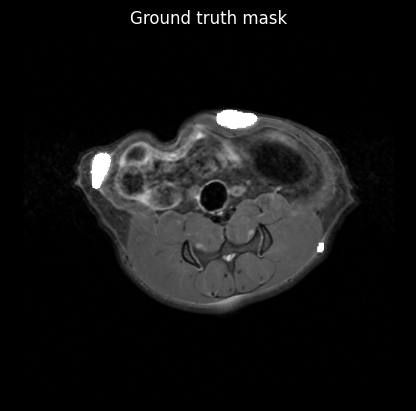

In [29]:
train_sam_ds.display_img_and_msk(idx=60)

### Create Train and Test Dataloader

In [30]:
train_dataloader = DataLoader(train_sam_ds, batch_size=CFG.TRAIN_BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_sam_ds, batch_size=CFG.TEST_BATCH_SIZE, shuffle=False)

In [31]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    if isinstance(v, torch.Tensor) or isinstance(v, np.ndarray):
        print(k, v.shape)
    else:
        print(k, type(v), len(v) if hasattr(v, '__len__') else v)


image path : data\8.33\T2-14J\Water\32_024_w.png
image path : data\8.32\T1-07J\Water\21_016_w.png
pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 576, 672])
filename <class 'list'> 2


In [32]:
def adjust_brightness(image, brightness=70):
    # Convert image to HSV (Hue, Saturation, Value) format
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Increase the V (Value) channel to make the image brighter
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, brightness)
    v = np.clip(v, 0, 255)  # Ensure pixel values are within valid range
    final_hsv = cv2.merge((h, s, v))

    # Convert back to BGR format
    bright_image = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

    return bright_image


In [33]:
# Function to draw a bounding box around the object in an image
def draw_bounding_box(image):

    # load_and_convert_image

    # Load the image
    image = cv2.imread(image)

    image = adjust_brightness(image)

    # Convert the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a blur to the image to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # blurred = cv2.GaussianBlur(np.array(image), (5, 5), 0)

    # Threshold the image to get the object in binary
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour, assuming the object to bound is the largest one
    largest_contour = max(contours, key=cv2.contourArea)

    # Draw a bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.imshow(image)

    x_min = x
    x_max = x + w
    y_min = y
    y_max = y + h

    return [x_min, y_min, x_max, y_max]


[101, 108, 566, 401]

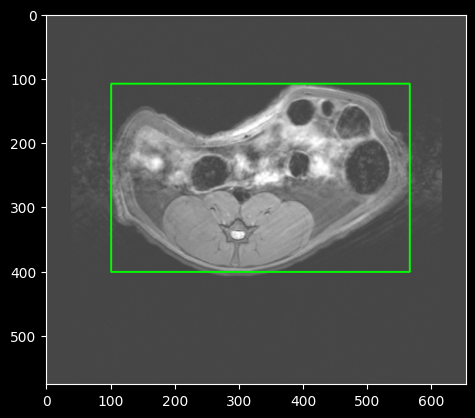

In [34]:
draw_bounding_box(train_dataset[110]['image_path'])

# Modeling

### Deactivate prompt encoder and image encoder parameters from being finetuned

In [35]:
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(CFG.DEVICE)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [36]:
# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY)
seg_loss = monai.losses.FocalLoss(reduction='mean')

In [ ]:
train_losses, train_ious, test_losses, test_ious = train_test_model (
    optimizer=optimizer,
    loss_function=seg_loss,
    num_epochs=CFG.EPOCH,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    device=CFG.DEVICE,
    target_width=max_w,
    target_height=max_h,
    save=False
)

EPOCH: 1


  0%|          | 0/206 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

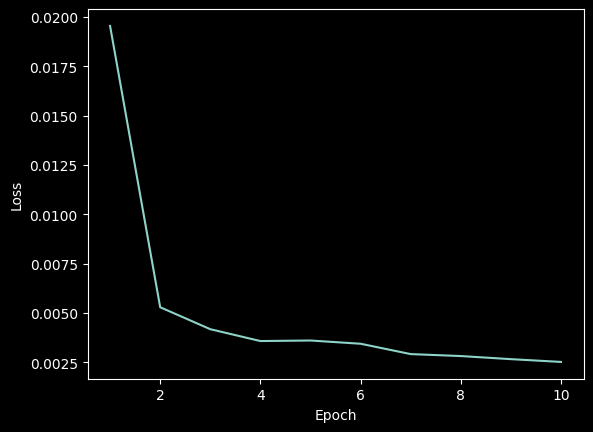

In [35]:
plt.plot(np.arange(1, CFG.EPOCH+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'IoU')

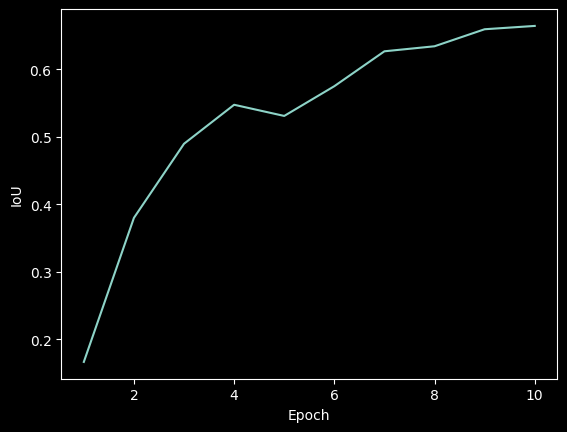

In [36]:
plt.plot(np.arange(1,CFG.EPOCH+1), train_ious)
plt.xlabel('Epoch')
plt.ylabel('IoU')

Text(0, 0.5, 'Loss')

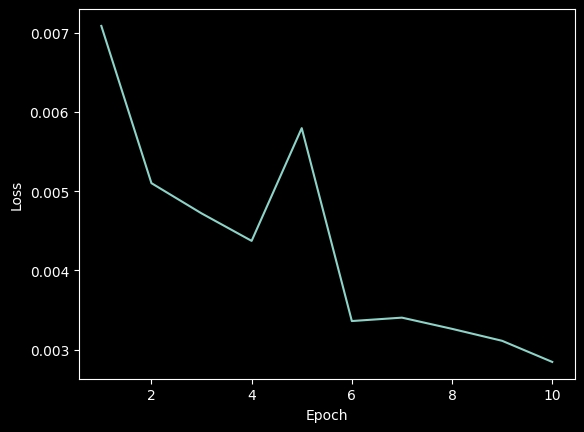

In [37]:
plt.plot(np.arange(1,CFG.EPOCH+1), test_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'IoU')

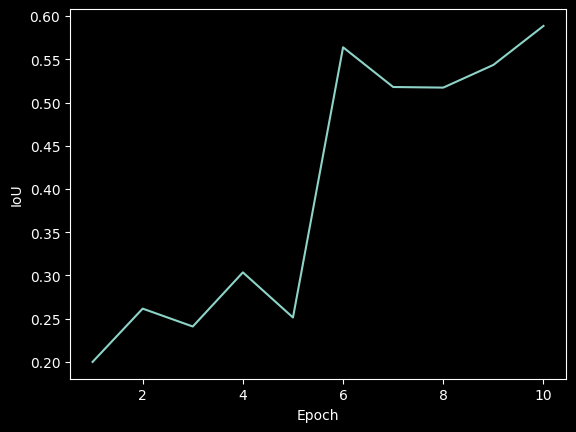

In [38]:
plt.plot(np.arange(1,CFG.EPOCH+1), test_ious)
plt.xlabel('Epoch')
plt.ylabel('IoU')

## TESTING WITH VISUALIZATION

### Create Custome test dataloader if necessary

In [37]:
from torch.utils.data import DataLoader
import datasets as dts
import pandas as pd

def create_custom_test_dataloader(
    ds,
    processor,
    max_h,
    max_w,
    week=None,
    subject=None,
):
    """
    Create a custom test DataLoader filtered by one or multiple weeks and/or subjects.

    Parameters
    ----------
    ds : pd.DataFrame
        The full dataset dataframe containing ['image_path', 'mask_path', 'week', 'subject'].
    processor : object
        SAM processor used in your SAMDataset class.
    CFG : config object
        Config class with TRAIN_BATCH_SIZE, TEST_BATCH_SIZE, etc.
    max_h, max_w : int
        Target height and width for padding.
    week : str, int, list, or None
        Week(s) to include. Example: 'D0', ['D0', 'D1'], or [0, 1].
    subject : str, float, list, or None
        Subject(s) to include. Example: '8.31', ['8.31', '8.32'], or [8.31, 8.32].

    Returns
    -------
    test_dataloader : DataLoader
    """

    df_filtered = ds.copy()

    # ✅ Handle week filtering (accepts single value or list)
    if week is not None:
        if not isinstance(week, (list, tuple, set)):
            week = [week]
        week = [str(w) for w in week]
        df_filtered = df_filtered[df_filtered["week"].astype(str).isin(week)]

    # ✅ Handle subject filtering (accepts single value or list)
    if subject is not None:
        if not isinstance(subject, (list, tuple, set)):
            subject = [subject]
        subject = [str(s) for s in subject]
        df_filtered = df_filtered[df_filtered["subject"].astype(str).isin(subject)]

    if df_filtered.empty:
        raise ValueError(f"No samples found for week={week}, subject={subject}")

    print(f"✅ Found {len(df_filtered)} samples for week={week}, subject={subject}")

    # ✅ Convert to Hugging Face dataset
    test_dataset = dts.Dataset.from_pandas(df_filtered.reset_index(drop=True))

    # ✅ Wrap into SAMDataset
    test_sam_ds = SAMDataset(dataset=test_dataset, processor=processor, target_height=max_h, target_width=max_w)

    # ✅ Create DataLoader
    test_dataloader = DataLoader(test_sam_ds, batch_size=CFG.TEST_BATCH_SIZE, shuffle=False)

    print(f"📦 Created test DataLoader with {len(test_sam_ds)} samples")

    return test_dataloader


In [38]:
custom_test_dataloader = create_custom_test_dataloader (
    ds=ds,
    processor=processor_custom,
    max_h=max_h,
    max_w=max_w,
    week=['T3-21J', "T4-28J"],
    subject= "8.31",
    )

✅ Found 82 samples for week=['T3-21J', 'T4-28J'], subject=['8.31']
📦 Created test DataLoader with 82 samples


### Load Pretrained model if necessary

Additionally, within the test function, I don't want to just get the prediction results, but also the corresponding iou values for each prediction. The way you can do this is by creating a new column with the original dataframe that contains the image paths. the new column will be called "IoU"

In [39]:
checkpoint_path = "models/sam_huge_first5.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

  0%|          | 0/82 [00:00<?, ?it/s]

image path : data\8.31\T3-21J\Water\13_000_w.png
IoU: tensor([[nan]], device='cuda:0')


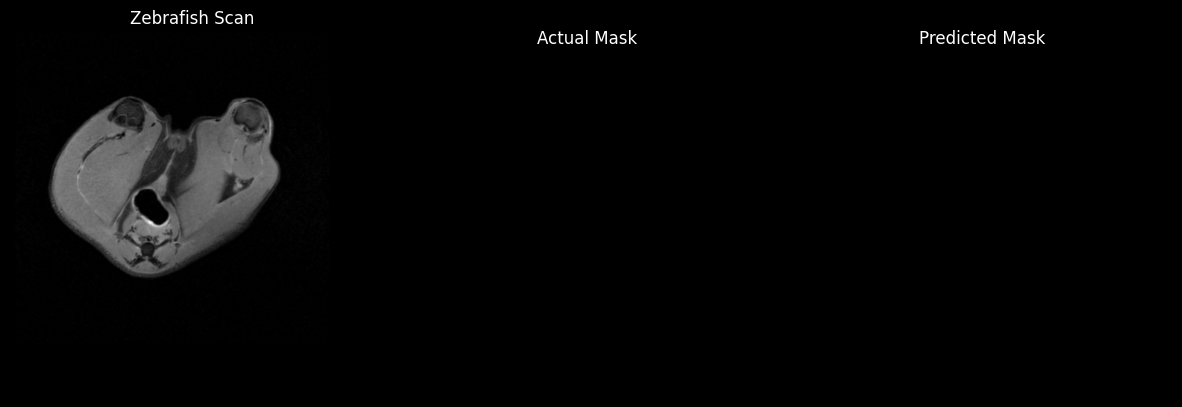

image path : data\8.31\T4-28J\Water\14_000_w.png
IoU: tensor([[nan]], device='cuda:0')


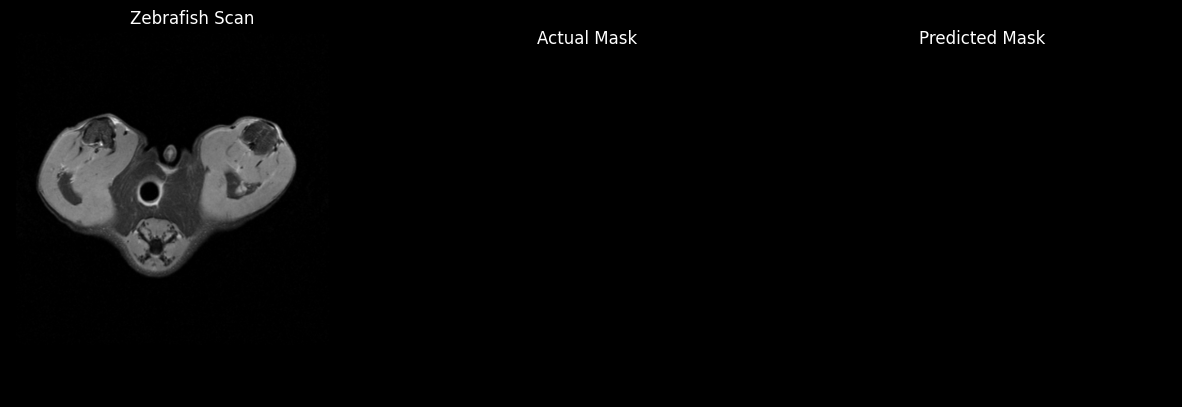

image path : data\8.31\T3-21J\Water\13_001_w.png
IoU: tensor([[nan]], device='cuda:0')


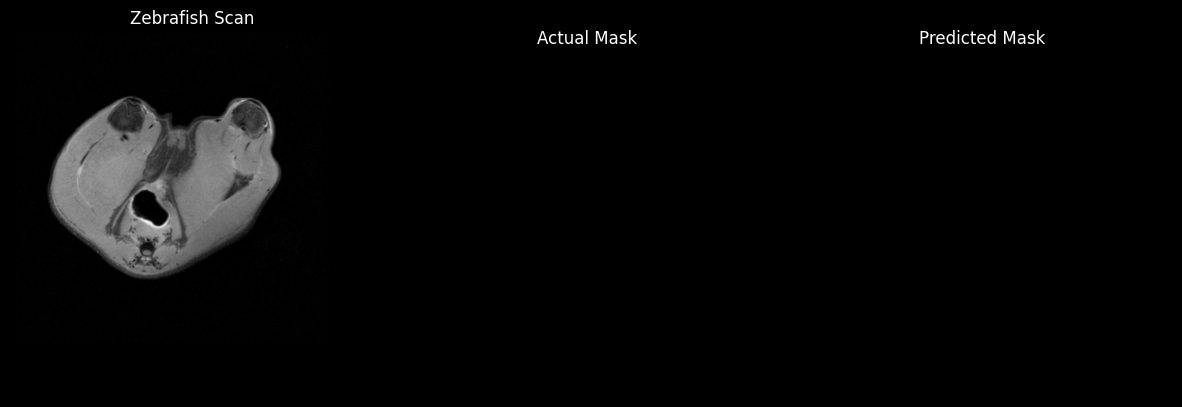

image path : data\8.31\T4-28J\Water\14_001_w.png
IoU: tensor([[nan]], device='cuda:0')


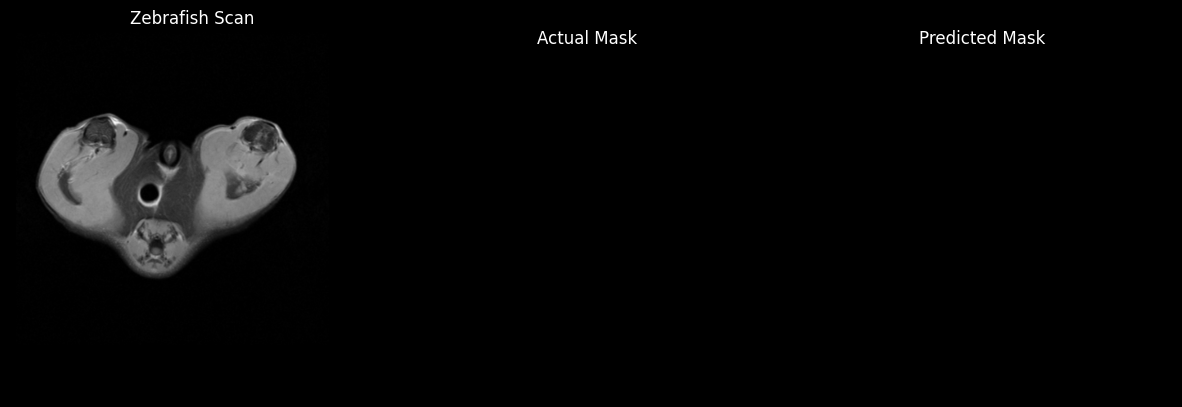

image path : data\8.31\T3-21J\Water\13_002_w.png
IoU: tensor([[0.0279]], device='cuda:0')


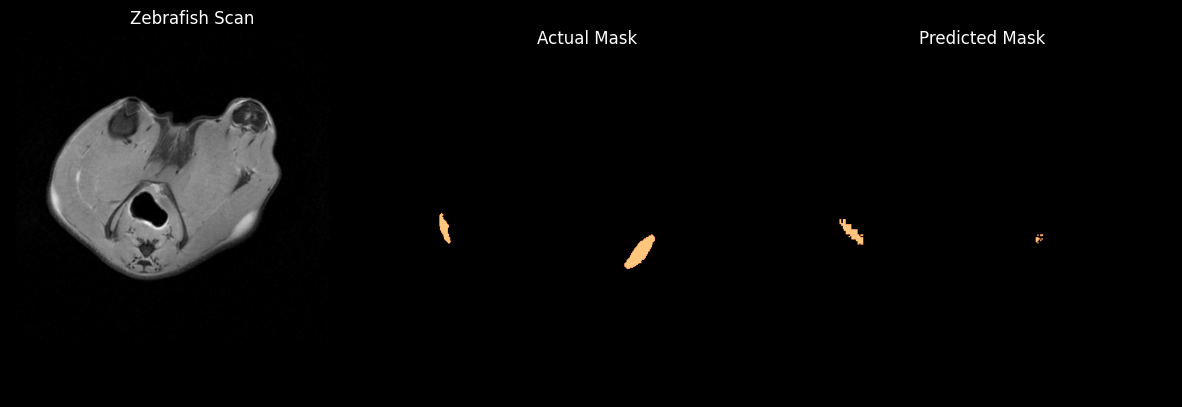

image path : data\8.31\T4-28J\Water\14_002_w.png
IoU: tensor([[nan]], device='cuda:0')


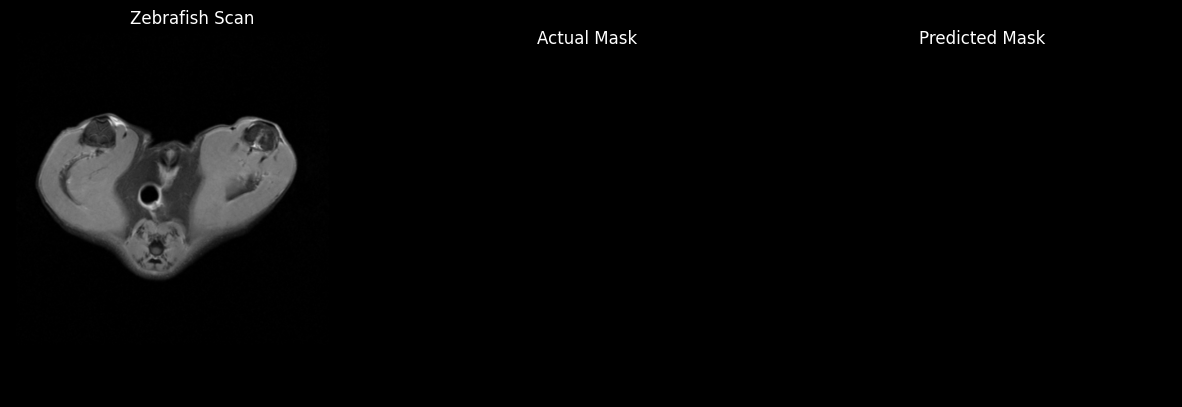

image path : data\8.31\T3-21J\Water\13_003_w.png
IoU: tensor([[0.1912]], device='cuda:0')


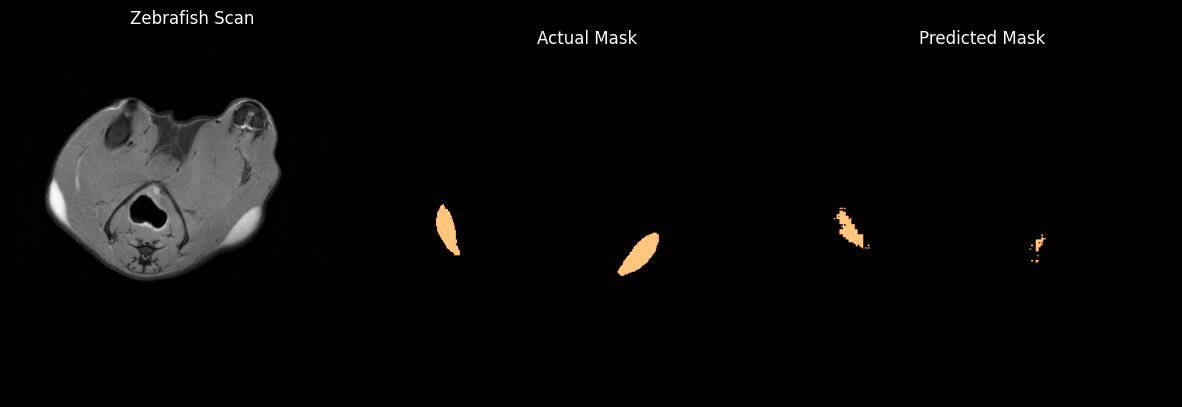

image path : data\8.31\T4-28J\Water\14_003_w.png
IoU: tensor([[nan]], device='cuda:0')


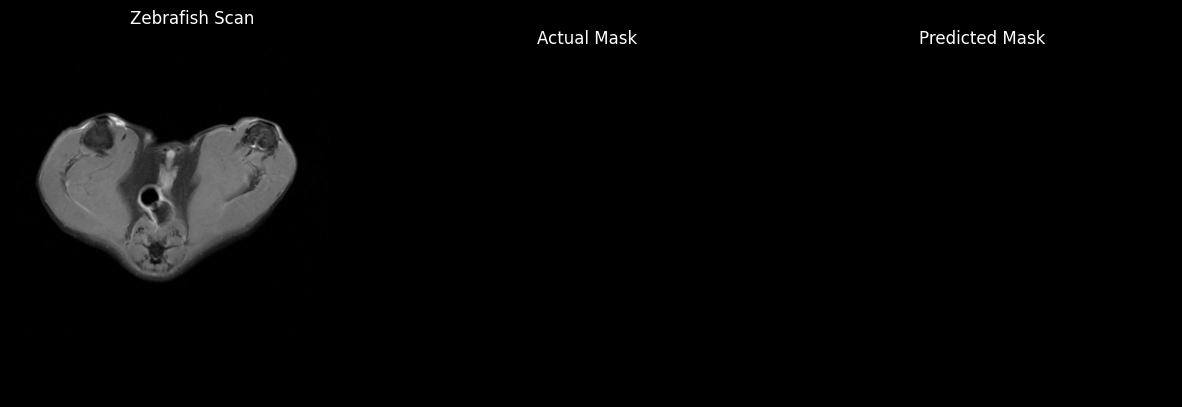

image path : data\8.31\T3-21J\Water\13_004_w.png
IoU: tensor([[0.2601]], device='cuda:0')


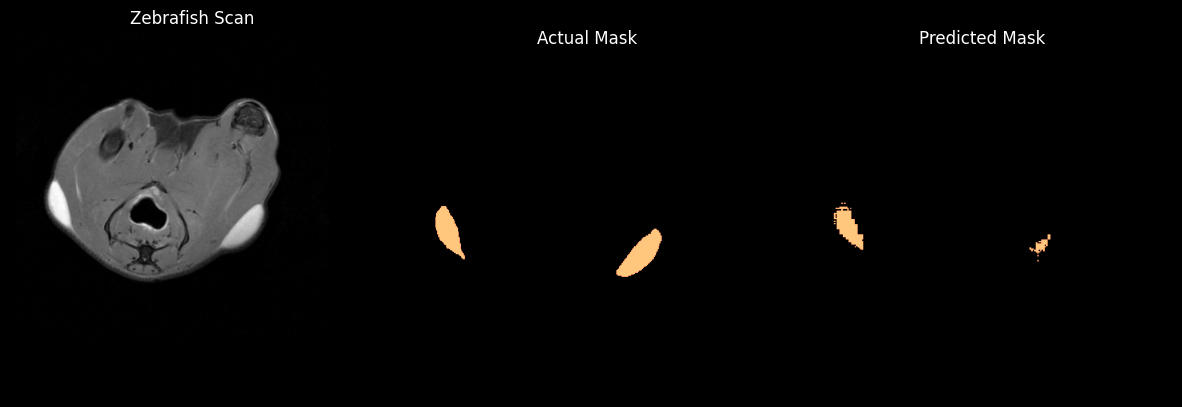

image path : data\8.31\T4-28J\Water\14_004_w.png
IoU: tensor([[0.]], device='cuda:0')


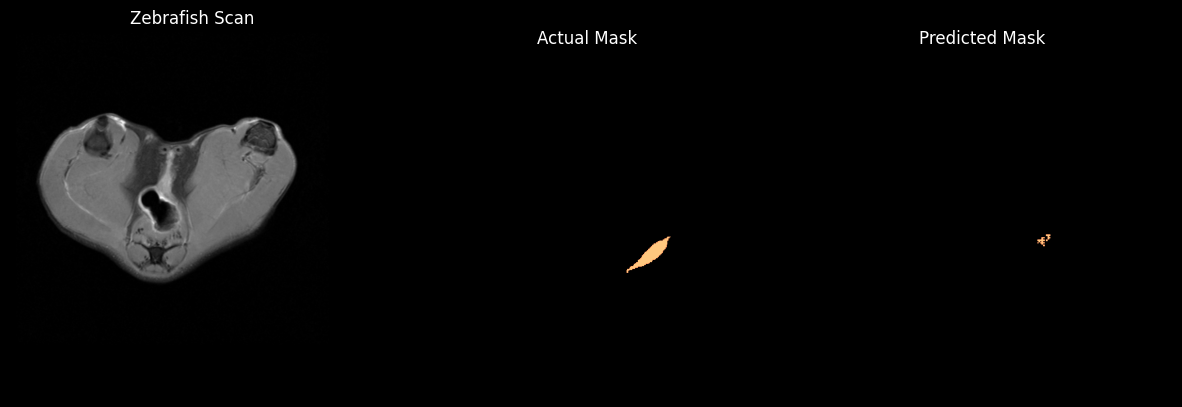

image path : data\8.31\T3-21J\Water\13_005_w.png
IoU: tensor([[0.3337]], device='cuda:0')


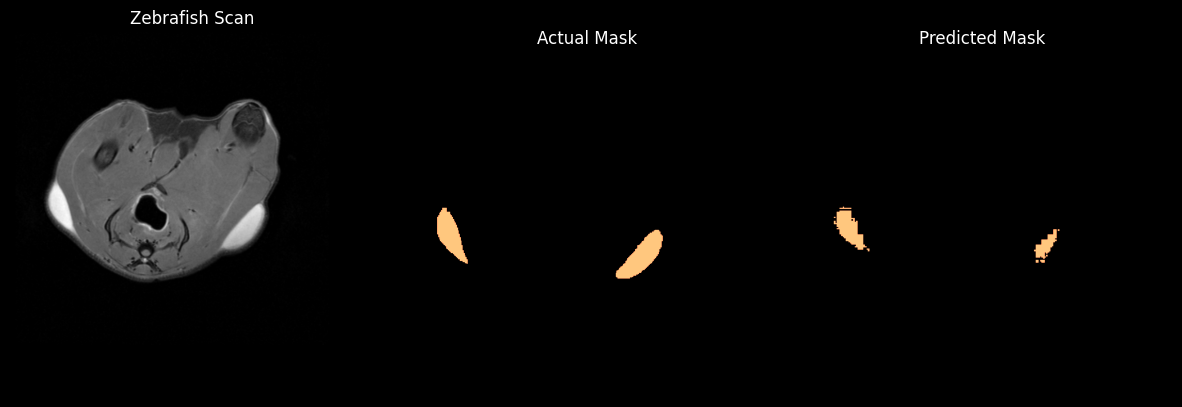

image path : data\8.31\T4-28J\Water\14_005_w.png
IoU: tensor([[0.0751]], device='cuda:0')


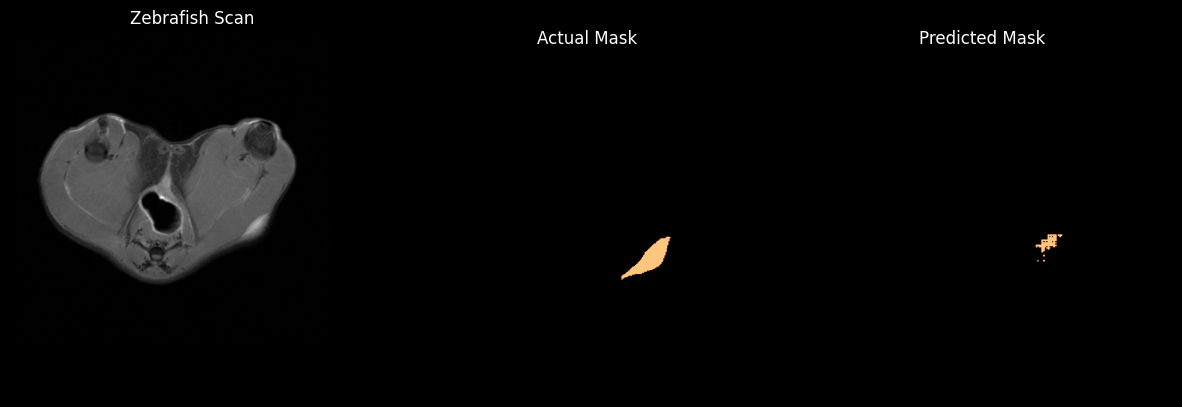

image path : data\8.31\T3-21J\Water\13_006_w.png
IoU: tensor([[0.2813]], device='cuda:0')


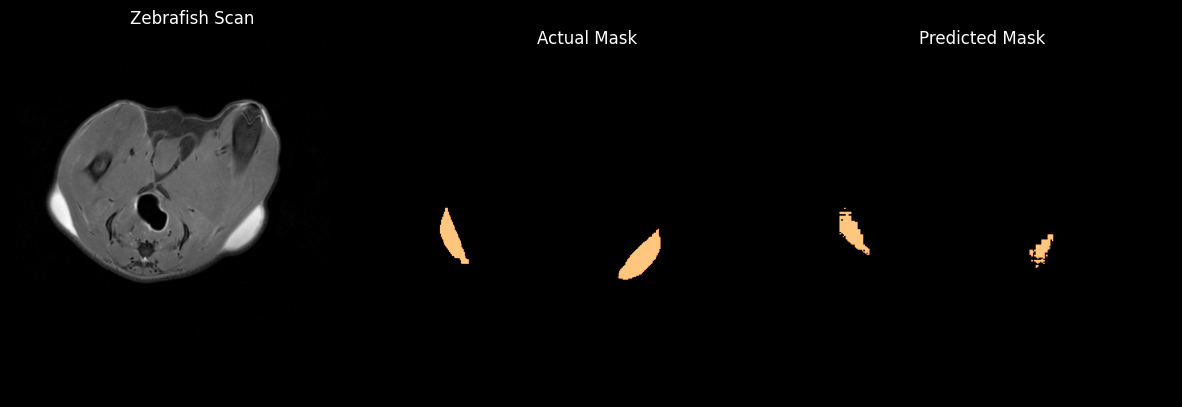

image path : data\8.31\T4-28J\Water\14_006_w.png
IoU: tensor([[0.2435]], device='cuda:0')


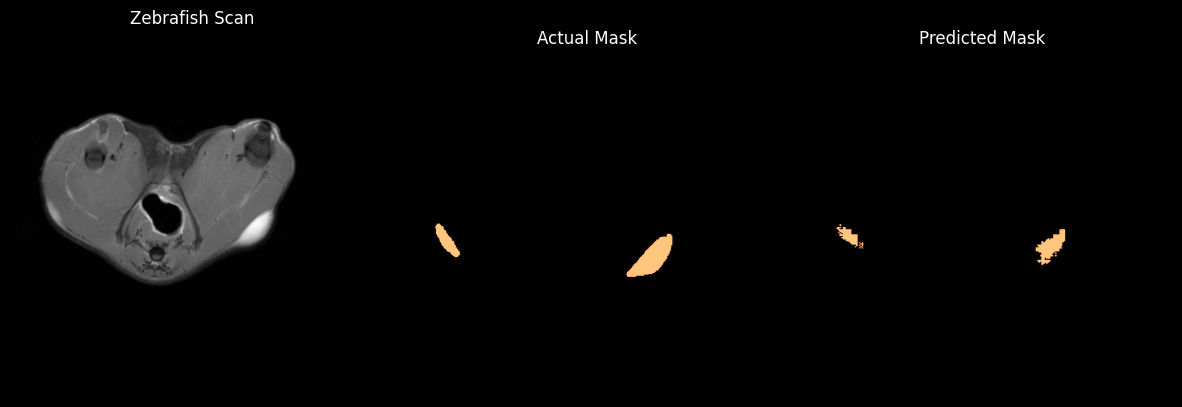

image path : data\8.31\T3-21J\Water\13_007_w.png
IoU: tensor([[0.1589]], device='cuda:0')


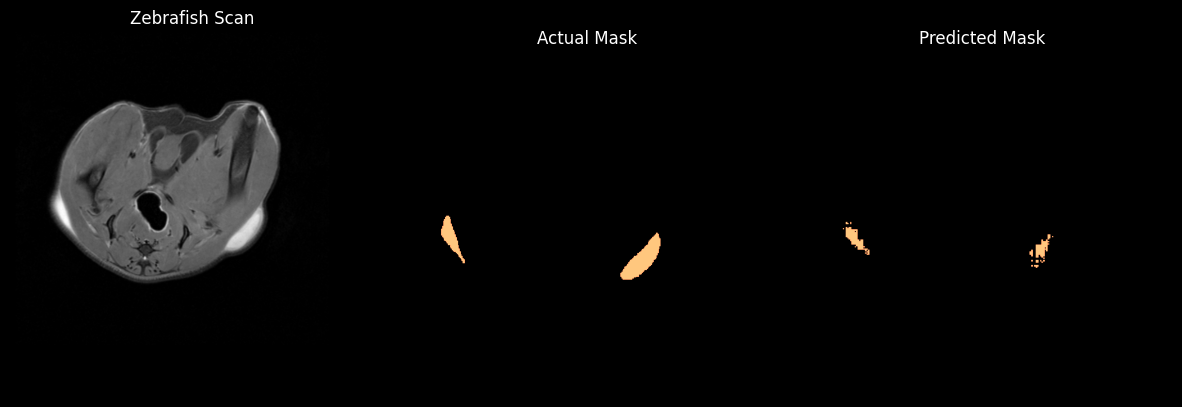

image path : data\8.31\T4-28J\Water\14_007_w.png
IoU: tensor([[0.2006]], device='cuda:0')


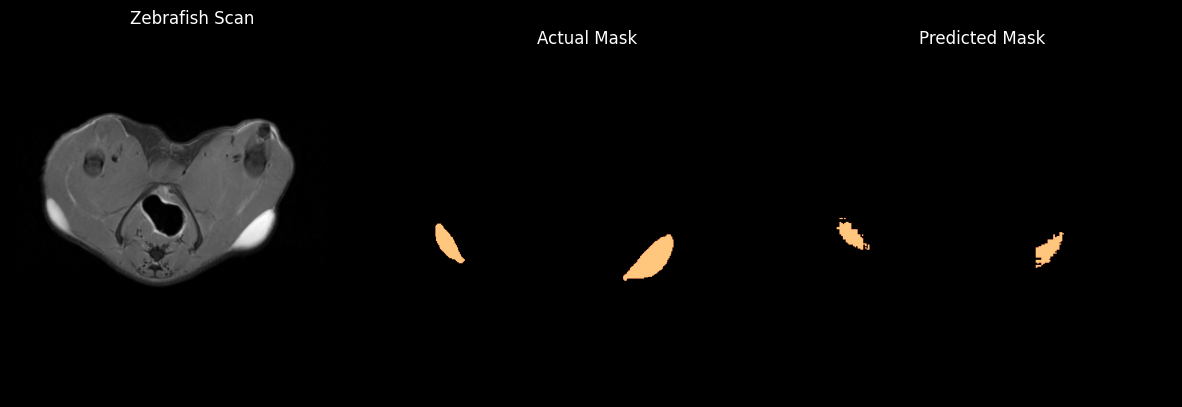

image path : data\8.31\T3-21J\Water\13_008_w.png
IoU: tensor([[0.0833]], device='cuda:0')


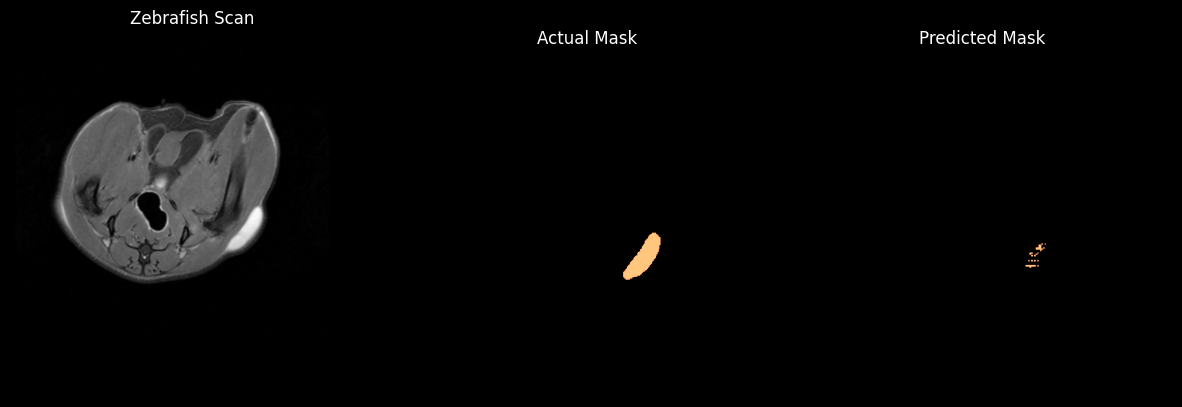

image path : data\8.31\T4-28J\Water\14_008_w.png
IoU: tensor([[0.2208]], device='cuda:0')


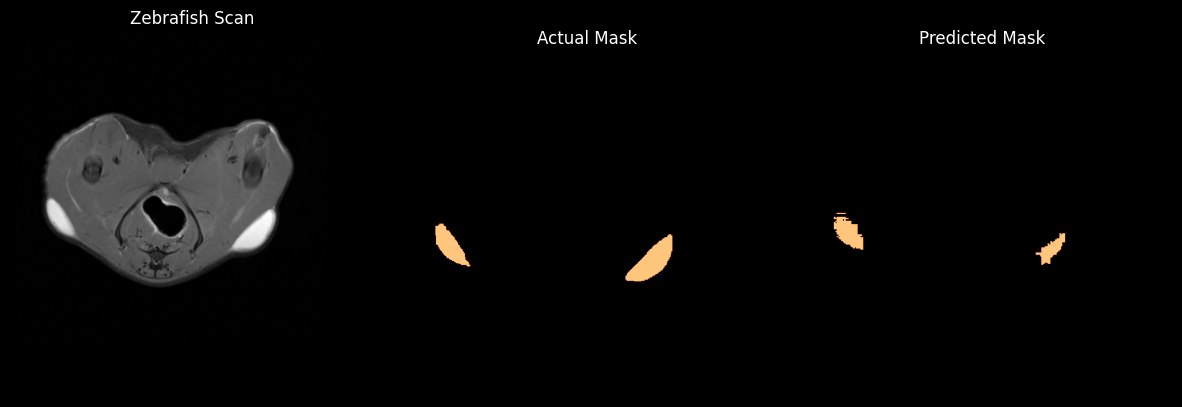

image path : data\8.31\T3-21J\Water\13_009_w.png


In [ ]:
ds_copy = test_with_visualization (test_dataloader=custom_test_dataloader,
                                   ds = ds,
                                   model=model,
                                   device=CFG.DEVICE,
                                   target_width=max_w,
                                   target_height=max_h,
                                   save = True,
                                   visualize = True)

In [43]:
subject_filter = "8.31"
week_filter = ["T3-21J", "T4-28J"]

# Filter DataFrame
filtered_df = ds_copy[
    (ds_copy["subject"] == subject_filter) &
    (ds_copy["week"].isin(week_filter))
]

# Export to JSON
filtered_df.to_json("iou.json", orient="records", indent=4)